In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import IPython
import IPython.display

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [13]:
# Loading the data
raw_data = pd.read_csv('delanteros.csv', sep=';',encoding='latin-1')
# Deleting the NULL values
raw_data = raw_data.dropna(subset = ['Tiros'])
raw_data = raw_data.dropna(subset = ['Tiros a puerta'])

# filtering out the last 2 columns
raw_data = raw_data[['Nombre','Fecha','Jornadas','Titular','Minutos','Goles','Asistencias','Tiros','Tiros a puerta']]

forecast_data = raw_data

forecast_data = forecast_data[~forecast_data['Nombre'].isin(['Lucas Boyé', 'Luis Javier Suárez', 'Alexander Isak', 'Rafa Mir'])]

# Limiting the columns we need
forecast_data = forecast_data[['Nombre','Jornadas','Minutos','Goles','Asistencias','Tiros','Tiros a puerta']]

#Original Data
original = forecast_data[forecast_data['Nombre'] == 'Karim Benzema']
original1 = original[['Jornadas','Minutos','Goles','Asistencias','Tiros','Tiros a puerta']]

# set the Jornada into index
original1.set_index('Jornadas', inplace=True)
original1


,Minutos,Goles,Asistencias,Tiros,Tiros a puerta
Jornadas,,,,,
1,90,0,0,1.0,0.0
2,90,2,0,2.0,1.0
3,90,2,0,4.0,3.0
4,90,0,0,2.0,0.0
5,59,0,0,1.0,0.0
...,...,...,...,...,...
114,90,0,0,2.0,0.0
115,90,1,0,8.0,4.0
116,90,0,0,1.0,1.0


In [14]:
original1_df1 = original1.diff(periods=1)
original1_df1.dropna(inplace=True)

In [15]:
column_indices = {name: i for i, name in enumerate(original1_df1.columns)}

n = len(original1_df1)
train_df = original1_df1[0:90]
val_df = original1_df1[90:110]
test_df = original1_df1[110:]

num_features = original1_df1.shape[1]

In [62]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [20]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [40]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=4, label_width=4, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 4, 5)
Labels shape (batch, time, features): (32, 4, 5)


## BaseLine

In [42]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [43]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [44]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 166ms/step - loss: 3.4957 - mean_absolute_error: 1.4780


In [45]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

## Denso

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [47]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 55ms/step - loss: 0.9792 - mean_absolute_error: 0.7509


## Denso multi paso

In [63]:
CONV_WIDTH = 4  #4 match before predict
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=4,
    shift=1)

conv_window

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): None

In [65]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=num_features),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [66]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 4, 5)
Output shape: (32, 1, 5)


In [67]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 59ms/step - loss: 1.2606 - mean_absolute_error: 0.8847


## Convulacional

In [57]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=num_features),
])

In [59]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 111ms/step - loss: 1.2302 - mean_absolute_error: 0.8619


## RNN

In [64]:
%%time
wide_window = WindowGenerator(
    input_width=4, label_width=4, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)


1/1 [==============================] - 0s 47ms/step - loss: 1.0817 - mean_absolute_error: 0.8085
Wall time: 6.2 s


Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): None

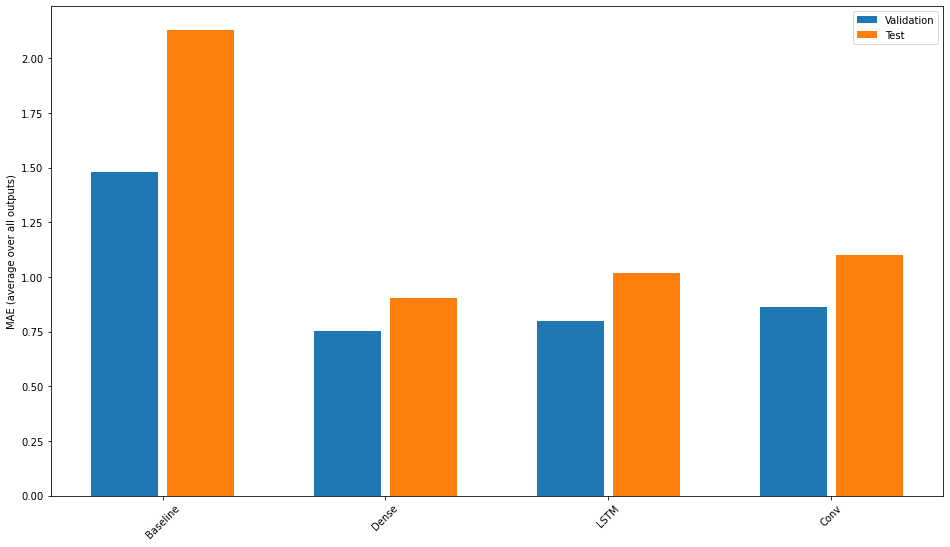

In [60]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [68]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 2.1306
Dense       : 0.9047
LSTM        : 1.0287
Conv        : 1.1016
Multi step dense: 1.1084
